<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/20_10_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv, DataFrame
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [2]:
# split a univariate dataset into train/test sets
def split_dataset(data, partition):
  # split into 'n_test' partitions
  train = data[:-partition]
  test = data[-partition:]
  train_original = train
  test_original = test

  # apply padding (if required) in order to split train and test array in equal windows
  if len(train) % partition != 0:
    pad_width = partition - (len(train) % partition)
    train = np.pad(train, (0,pad_width), 'constant', constant_values=(array(train).mean()))

  if len(test) % partition != 0:
    pad_width = partition - (len(test) % partition)
    test = np.pad(test, (0,pad_width), 'constant', constant_values=(array(test).mean()))
    
  # restructure into windows of quarterly data
  train = array(split(train, int(len(train)/partition)))
  test = array(split(test, int(len(test)/partition)))
  return train, test, train_original, test_original
  #return train, test

In [3]:
# evaluate one or more forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each 
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores


In [4]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))


In [5]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)


In [6]:
# train the model
def build_model(train, n_steps, n_length, n_input, n_out):
	# prepare data
	train_x, train_y = to_supervised(train, n_input, n_out)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 12
	n_features, n_outputs = train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, timesteps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [7]:
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [samples, timesteps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
	# forecast the next sequence
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [8]:
# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input, n_out):
	# fit model
	model = build_model(train, n_steps, n_length, n_input, n_out)
	# history is a list of data
	history = [x for x in train]
	# walk-forward validation over each window
	predictions = list()
	for i in range(len(test)):
		# predict the sequence
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get predicted observation and add to history for predicting the next sequence
		history.append(yhat_sequence)
	# evaluate predictions days for each sequence
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions

Read Dataset

In [9]:
df = read_csv('/content/RevenueJuly.csv')
series = DataFrame(df['Revenue'])
data = series.values

In [10]:
partition = 7
train, test, train_original, test_original = split_dataset(data, partition)

In [11]:
train.shape, test.shape

((7, 7, 2), (1, 7, 1))

In [12]:
train_original.shape, test_original.shape

((48, 1), (7, 1))

In [13]:
# define the number of subsequences and the length of subsequences
n_steps, n_length = 1, 12
n_out = 7
# define the total days to use as input
n_input = n_length * n_steps

In [14]:
score, scores, pred = evaluate_model(train, test, n_steps, n_length, n_input, n_out)
# summarize scores
summarize_scores('lstm', score, scores)

lstm: [57120.260] 32850.5, 30896.7, 74583.4, 82723.7, 4022.8, 89476.9, 19419.4


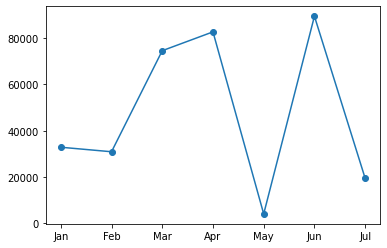

In [15]:
# plot scores
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']
plt.plot(month_list, scores, marker='o', label='lstm')
plt.show()

convert predicted, train and test values to a list

In [16]:
predictions = pred.reshape(-1).tolist()
predictions

[49357.80859375,
 86161.9453125,
 57684.16796875,
 103274.4453125,
 49780.76953125,
 94238.2890625,
 54806.1875]

In [17]:
test_values_list = test_original.reshape(-1).tolist()
test_values_list

[16507.335,
 55265.293,
 132267.59699999998,
 20550.787,
 45757.982,
 183715.237,
 74225.599]

In [18]:
train_values_list = train_original.reshape(-1).tolist()
train_values_list

[11141.566,
 11483.52,
 89026.192,
 7486.732,
 17719.978,
 159129.659,
 16736.302,
 25432.066000000003,
 145620.785,
 24954.743,
 42440.280999999995,
 389795.30100000004,
 10851.367,
 15156.59,
 92459.405,
 18964.488999999998,
 27080.474,
 156189.554,
 22733.732000000004,
 19094.521,
 119631.54800000001,
 21636.455,
 64590.779,
 303152.06,
 12594.348,
 24780.076,
 116146.579,
 32970.437000000005,
 48772.3,
 285241.25800000003,
 27898.502999999997,
 51343.677,
 244466.379,
 34864.443,
 73066.245,
 724737.205,
 16301.221000000001,
 19769.781000000003,
 119442.079,
 18721.319,
 30299.276,
 226961.657,
 25759.943,
 35032.793,
 147118.56699999998,
 43656.223,
 54935.815,
 519504.737]

In [19]:
#Evaluate Model using r2_score and RMSE
MSE = mean_squared_error(test_values_list, predictions)
RMSE = int(sqrt(MSE))
R2 = r2_score(test_values_list,predictions)
print('RMSE : ' + str(RMSE))
print('R square : ' + str(R2))

RMSE : 57120
R square : -0.004873745457149914


In [20]:
#set x axis labels
vis = dict()

x_axis_label = []

for cur_year in df['Year']:
  if str(cur_year) not in vis.keys():
    vis[str(cur_year)] = 1
    x_axis_label.append(str(cur_year))
  
  else:
    x_axis_label.append('')
  

In [21]:
x_axis_label

['2017',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2018',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2019',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2020',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2021',
 '',
 '',
 '',
 '',
 '',
 '']

specify dates

In [22]:
dates_train = []
for i in range(len(df)-partition):
  dates_train.append( str(df['Year'][i]) + "-" + str(df['Month'][i]) )

dates_train

['2017-1',
 '2017-2',
 '2017-3',
 '2017-4',
 '2017-5',
 '2017-6',
 '2017-7',
 '2017-8',
 '2017-9',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-1',
 '2018-2',
 '2018-3',
 '2018-4',
 '2018-5',
 '2018-6',
 '2018-7',
 '2018-8',
 '2018-9',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-1',
 '2019-2',
 '2019-3',
 '2019-4',
 '2019-5',
 '2019-6',
 '2019-7',
 '2019-8',
 '2019-9',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-1',
 '2020-2',
 '2020-3',
 '2020-4',
 '2020-5',
 '2020-6',
 '2020-7',
 '2020-8',
 '2020-9',
 '2020-10',
 '2020-11',
 '2020-12']

In [23]:
dates_test = []
for i in range(len(df)-partition , len(df)):
  dates_test.append( str(df['Year'][i]) + "-" + str(df['Month'][i]) )

dates_test

['2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7']

Compute confidence/prediction interval

In [24]:
x_bar = array(test_values_list).mean()

In [25]:
sum = 0
for i in range(partition):
  t = (test_values_list[i]-x_bar)**2
  sum = sum + t

In [26]:
def compute_std_error(xh):
  temp1 = 1.0 + (1.0/partition) 
  temp2 = float((xh - x_bar)**2) / sum
  return sqrt(MSE * (temp1+temp2))

In [27]:
confidence_upper = []
confidence_lower = []
t_multiplier = 2.228

In [28]:
for i in range(partition):
  std_error = compute_std_error(test_values_list[i])
  val = t_multiplier * std_error
  confidence_upper.append(predictions[i] + val)
  temp = predictions[i] - val
  confidence_lower.append(max(temp,0))

In [29]:
confidence_upper

[194227.57501929862,
 223277.74739012262,
 201936.22492732815,
 247007.23813570093,
 188124.26455183048,
 258126.55124192507,
 190861.11690721978]

Plot Graph

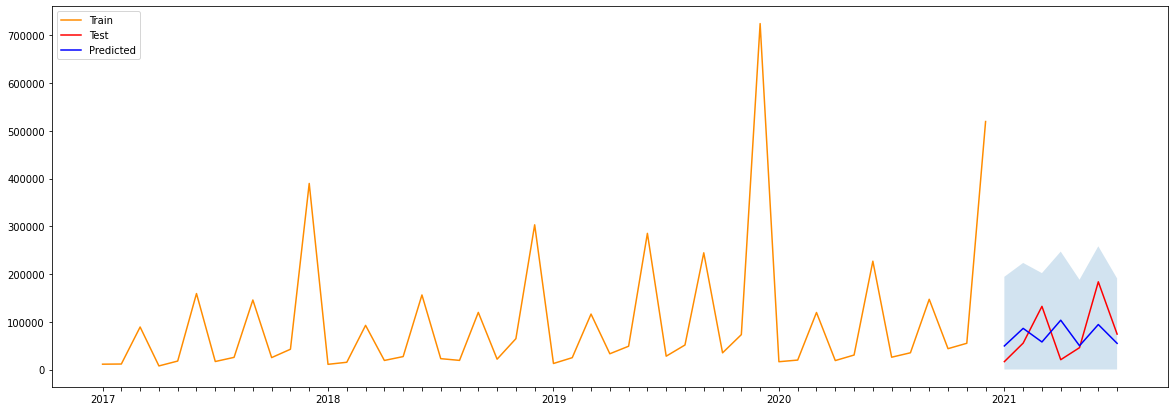

In [30]:
plt.figure(figsize=(20,7))
plt.plot(dates_train, train_values_list, color='darkorange', label="Train")
plt.plot(dates_test, test_values_list, color='red', label="Test")
plt.plot(dates_test, predictions, color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()